In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Nov 10 13:56:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd drive/MyDrive/Colab\ Notebooks/dec-pt

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/dec-pt


In [ ]:
import sys, os

sys.path.append(os.getcwd())
import torch.utils.data as data
from torchvision import datasets, transforms
from models.stacked_dae import StackedDenoisingAE
import numpy as np
import pandas as pd
from utils.utils import Dataset
import torch
import torch.utils.data as Data
from models.dec import DEC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial import distance_matrix as dm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
%ls -a

data/                q_cluster_assign_prob.npy  test_sdae.py
.git/                q_test.npy                 utils/
.gitignore           q_train.npy                Visualize_DEC.ipynb
.idea/               README.md                  z_embeddings.npy
.ipynb_checkpoints/  results/                   z_train.npy
models/              test_dec.py                z_traz_testin.npy


In [ ]:
cell_types = np.loadtxt("data/Haleh/cell_types.txt", delimiter=',')
traces = np.genfromtxt("data/Haleh/activity_traces.txt", delimiter=',', usecols=np.arange(0,1725))
print(traces.shape)
print(cell_types.shape)

(5384, 1725)
(5384,)


In [ ]:
np.unique(cell_types)

array([-1.,  1.])

In [ ]:
def calc_cluster_density(q, ind_inh, ind_exc, latent_dim):
  _, y_pred = torch.max(q, dim=1)
  y_pred = y_pred.data.cpu().numpy()
  clusters, size = np.unique(y_pred, return_counts=True)
  densities = []
  sizes = []
  inh_cluster = y_pred[ind_inh]
  for i in range(latent_dim):
    if i in clusters:
      inh_size = np.sum((inh_cluster == i))
      sz = size[clusters==i]
      sizes.append(sz[0])
      densities.append(inh_size/sz)
    else:
      inh_size = 0.0
      sz = 0.0
      sizes.append(sz)
      densities.append(0.0)
  return np.array(densities).squeeze(), np.array(sizes).squeeze()


In [ ]:
latent_dim = 10
input_dim = traces.shape[1]

hidden_dims = [1000, 500, 2000]

traces = torch.FloatTensor(traces)
dataset = Dataset(traces, cell_types)
train_len = int(dataset.data.shape[0] * 0.8)
train_set, val_set = torch.utils.data.random_split(dataset, [train_len, dataset.data.shape[0]-train_len])

train_loader = Data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = Data.DataLoader(val_set, batch_size=128, shuffle=True)

hidden_dims = [1000, 500, 2000]
dec = DEC(input_dim=input_dim, latent_dim=latent_dim, n_clusters=5, hidden_dims=hidden_dims, dropout=0.0, acc='accuracy')
print(dec)
dec.load_model('results/dec_10_5.pt')
dec.to('cuda')

X = dataset.data
y = torch.from_numpy(dataset.labels.astype(np.int64))
dec.fit(X, y, lr=0.01, num_clusters=5, batch_size=128, num_epochs=50, stop_criterion=0.001)
X_test = traces
y_test = cell_types
X_test = X_test.type(torch.FloatTensor)
X_test = X_test.view(-1, X_test.shape[1])
q, z = dec.forward(X_test.to('cuda'))
_, y_pred = torch.max(q, dim=1)
y_pred = y_pred.data.cpu().numpy()

DEC(
  (encoder): Sequential(
    (0): Sequential(
      (linear): Linear(in_features=1725, out_features=1000, bias=True)
      (activation): ReLU()
    )
    (1): Sequential(
      (linear): Linear(in_features=1000, out_features=500, bias=True)
      (activation): ReLU()
    )
    (2): Sequential(
      (linear): Linear(in_features=500, out_features=2000, bias=True)
      (activation): ReLU()
    )
    (3): Sequential(
      (linear): Linear(in_features=2000, out_features=10, bias=True)
    )
  )
)
==========Training Deep Embedding Clustering Model==========
Current Error: 0.000
Epoch No. 0: Loss: 0.103, Accuracy: 0.248, NMI Score: 0.004
Current Error: 0.003
Epoch No. 1: Loss: 0.097, Accuracy: 0.248, NMI Score: 0.004
Current Error: 0.007
Epoch No. 2: Loss: 0.094, Accuracy: 0.248, NMI Score: 0.004
Current Error: 0.011
Epoch No. 3: Loss: 0.090, Accuracy: 0.247, NMI Score: 0.004
Current Error: 0.012
Epoch No. 4: Loss: 0.087, Accuracy: 0.248, NMI Score: 0.004
Current Error: 0.014
Epoch No

In [ ]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

In [ ]:
X_embedded_dec = TSNE(n_components=2).fit_transform(z.cpu().detach().numpy())
print(X_embedded_dec.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(5384, 2)


In [ ]:
pca = PCA(n_components=10)
pca.fit(traces)

[0.13568632 0.10721768 0.08311146 0.06076873 0.04259535 0.03561336
 0.02958236 0.02116065 0.01990717 0.01804345]


In [ ]:
z_traces = pca.transform(traces)

In [ ]:
X_embedded_pca = TSNE(n_components=2).fit_transform(z_traces)
print(X_embedded_pca.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(5384, 2)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(z_traces)
pca_labels = kmeans.labels_
pca_clustered = kmeans.fit_transform(z_traces)

In [ ]:
X_embedded_pca_clust = TSNE(n_components=2).fit_transform(pca_clustered)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
from sklearn.metrics import davies_bouldin_score, silhouette_score
db_pca = davies_bouldin_score(z_traces, pca_labels)
slc_pca = silhouette_score(z_traces, pca_labels)
db_dec = davies_bouldin_score(z.data.cpu().numpy(), y_pred)
slc_dec = silhouette_score(z.data.cpu().numpy(), y_pred)

print(f'Davies-Bouldin PCA: \t{db_pca:.2f}')
print(f'Silhouette-Score PCA: \t{slc_pca:.2f}')
print(f'Davies-Bouldin DEC: \t{db_dec:.2f}')
print(f'Silhouette-Score PCA: \t{slc_dec:.2f}')

Davies-Bouldin PCA: 	1.58
Silhouette-Score PCA: 	0.18
Davies-Bouldin DEC: 	0.13
Silhouette-Score PCA: 	0.91


In [ ]:
print(np.unique(cell_types, return_counts=True))

(array([-1.,  1.]), array([ 701, 4683]))


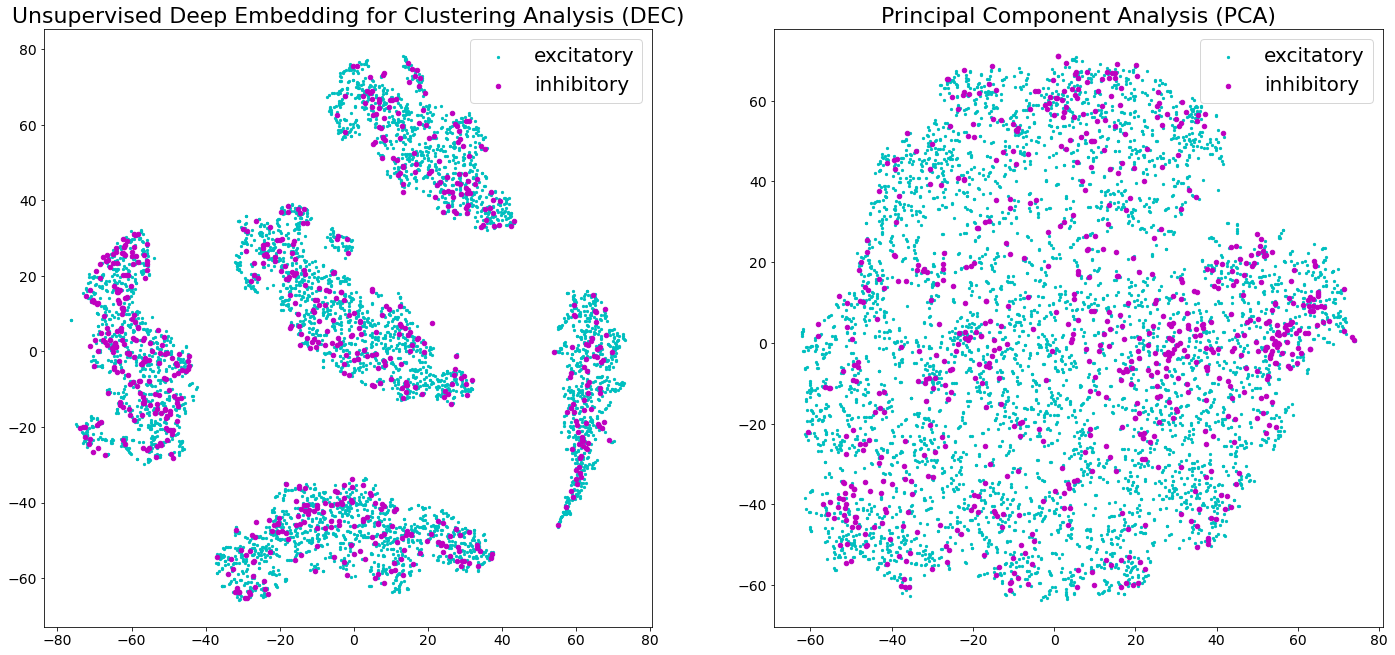

In [ ]:
y_test = cell_types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 11))
plt.rcParams.update({'font.size': 14})

ind_inh = np.where(y_test == -1.0)
ind_exc = np.where(y_test == 1.0)
ax1.scatter(X_embedded_dec[ind_exc, 0], X_embedded_dec[ind_exc, 1], s=5, label='excitatory', c='c')
ax1.scatter(X_embedded_dec[ind_inh, 0], X_embedded_dec[ind_inh, 1], s=20, label='inhibitory', c='m')
ax1.set_title('Unsupervised Deep Embedding for Clustering Analysis (DEC)', fontsize=22)
ax1.legend(fontsize=20)

ax2.scatter(X_embedded_pca[ind_exc, 0], X_embedded_pca[ind_exc, 1], s=5, label='excitatory', c='c')
ax2.scatter(X_embedded_pca[ind_inh, 0], X_embedded_pca[ind_inh, 1], s=20, label='inhibitory', c='m')
ax2.set_title('Principal Component Analysis (PCA)', fontsize=22)
ax2.legend(fontsize=20)

#plt.show()   
plt.savefig('results/t-SNE_{}.png'.format(latent_dim))

In [ ]:
_, y_pred = torch.max(q, dim=1)
y_pred = y_pred.data.cpu().numpy()

In [ ]:
print(np.unique(y_pred))

[0 1 2 3 4]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



0.13020059435364043


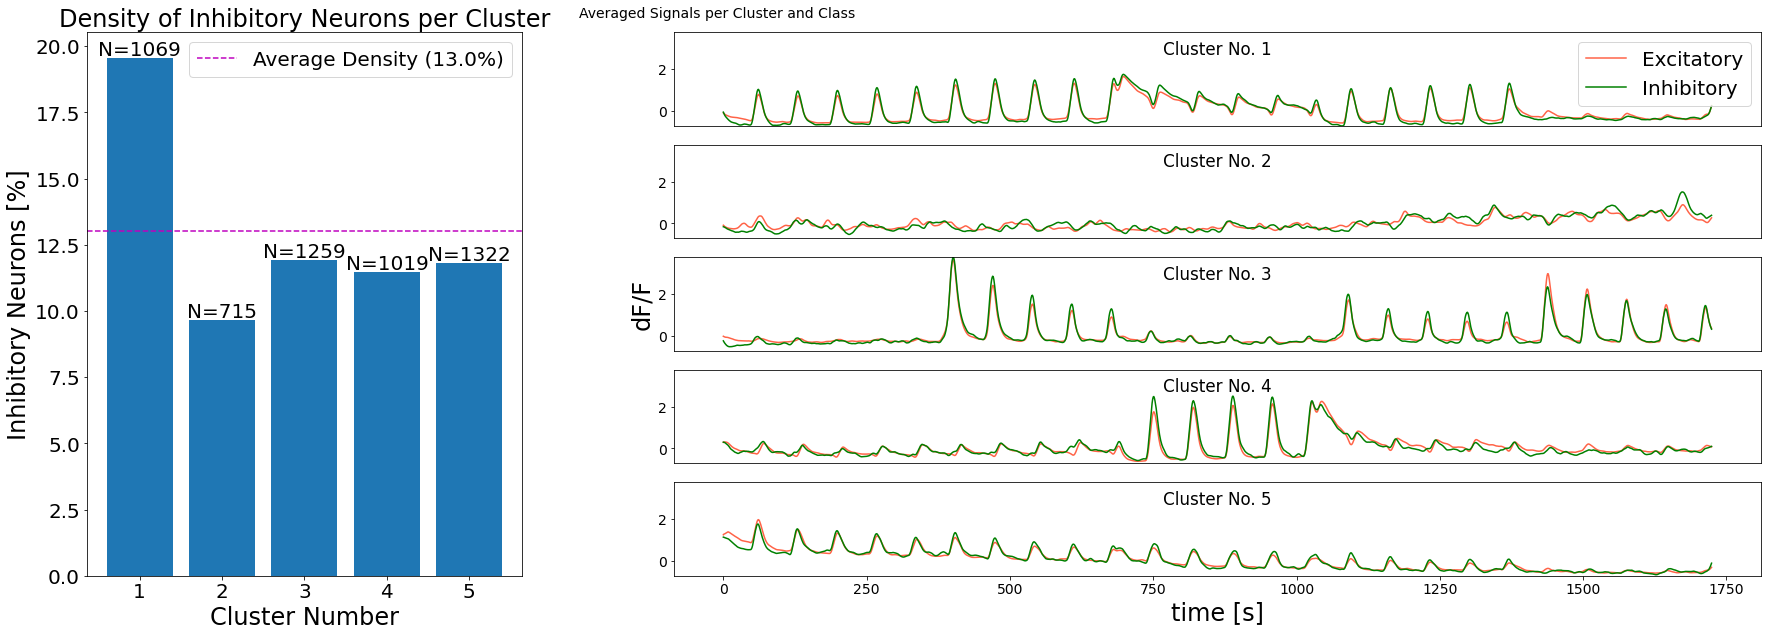

In [ ]:
from matplotlib import gridspec
#plt.rcParams.update({'font.size': 20})

densities, sizes = calc_cluster_density(q, ind_inh, ind_exc, latent_dim=latent_dim)
densities = densities * 100
density = len(ind_inh[0]) / (len(ind_inh[0]) + len(ind_exc[0]))
weights = sizes/sizes.sum()
print(density)


x = np.arange(1, 6)
epsilon = 1e-4

fig = plt.figure(figsize=(30, 10))
gs0 = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5], figure=fig)
ax0 = plt.subplot(gs0[0])
gs00 = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[1])


ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])
ax3 = fig.add_subplot(gs00[2])
ax4 = fig.add_subplot(gs00[3])
ax5 = fig.add_subplot(gs00[4])

axes = [ax1, ax2, ax3, ax4, ax5]

ax0.set_title('Density of Inhibitory Neurons per Cluster', fontsize=24)
ax0.axhline(y=density*100, color='m', linestyle='dashed', label=f'Average Density ({density*100:.1f}%)')
ax0.set_xlabel('Cluster Number', fontsize=24)
ax0.set_ylabel('Inhibitory Neurons [%]', fontsize=24)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.bar(x, np.concatenate(densities[:5]).ravel())
for i in range(5):
    if int(sizes[i]) == 715:
      ax0.text(x = x[i]-0.42 , y = densities[i]+0.1, s = 'N={}'.format(int(sizes[i])), size = 20)
    else:
      ax0.text(x = x[i]-0.5 , y = densities[i]+0.1, s = 'N={}'.format(int(sizes[i])), size = 20)
ax0.legend(loc='upper right', fontsize=20)

num_clusters = 5
#plt.setp(axes, title='Averaged Signals per Cluster')
#X_test = X_test.data.cpu().numpy()
min_signal = 2000
max_signal = -2000

for i in range(num_clusters):
  signals = X_test[y_pred == i]
  signals_inh = X_test[(y_pred == i) * (y_test == -1)]
  signals_exc = X_test[(y_pred == i) * (y_test == 1)]

  avg_exc = signals_exc.mean(axis=0)
  avg_inh = signals_inh.mean(axis=0)

  cat_signal = np.concatenate((avg_exc, avg_inh))

  if np.min(cat_signal) < min_signal:
    min_signal = np.min(cat_signal)
  if np.max(cat_signal) > max_signal:
    max_signal = np.max(cat_signal)

  axes[i].plot(avg_exc, color='tomato', label=f'Excitatory')
  axes[i].plot(avg_inh, color='green', label=f'Inhibitory')
  axes[i].set_ylim([min_signal, max_signal])
  if i < 4:
    axes[i].set_xticks([])
  #ax2.set_title('Averaged Signals per Cluster'.format(i+1))
handles, labels = axes[-1].get_legend_handles_labels()
axes[0].text(, 5.0, "Averaged Signals per Cluster and Class", va="top", ha="center")
axes[0].legend(handles, labels, fontsize=20)
axes[-1].set_xlabel('time [s]', fontsize=24)
axes[2].set_ylabel('dF/F', fontsize=24)

for i, ax in enumerate(axes):
  ax.set_ylim([min_signal, max_signal])
  ax.set_title(f'Cluster No. {i+1}', y=0.70)
plt.show()
#plt.savefig('results/ClusterDensityAndSignals.png')